In [ ]:
## Notebook env: brian_script_env (R kernel)
## This notebook identifies guides that saw high knockdown in the CRISPRi cell culture screen

In [1]:
library(ggplot2)
library(ggpubr)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
library(Matrix)
library(sparseMatrixStats)
library(dplyr)
library(tidyr)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


The following object is masked from ‘package:reshape2’:

    smiths




In [2]:
assignments_CRISPRi = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/geomux_output_assignments_CRISPRi.csv')

In [3]:
CRISPRi_screen = Read10X_h5('/home/ssobti/projects/heterogeneity_brian/data/032923_MD231_CRISPRi_CRISPRa_screen/230329_A01102_0587_AH3CY5DSX7_S4_200/cellranger/combined_G12/outs/count/filtered_feature_bc_matrix.h5')

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Genome matrix has multiple modalities, returning a list of matrices for this genome



In [4]:
CRISPRi_seurat = CreateSeuratObject(CRISPRi_screen[['Gene Expression']])

In [5]:
CRISPRi_seurat = CRISPRi_seurat[,assignments_CRISPRi$barcode]

In [6]:
dim(CRISPRi_seurat)

[1] 36601  7700

In [7]:
CRISPRi_seurat@meta.data = cbind(CRISPRi_seurat@meta.data, select(assignments_CRISPRi, -c('barcode', 'barcode.1')))

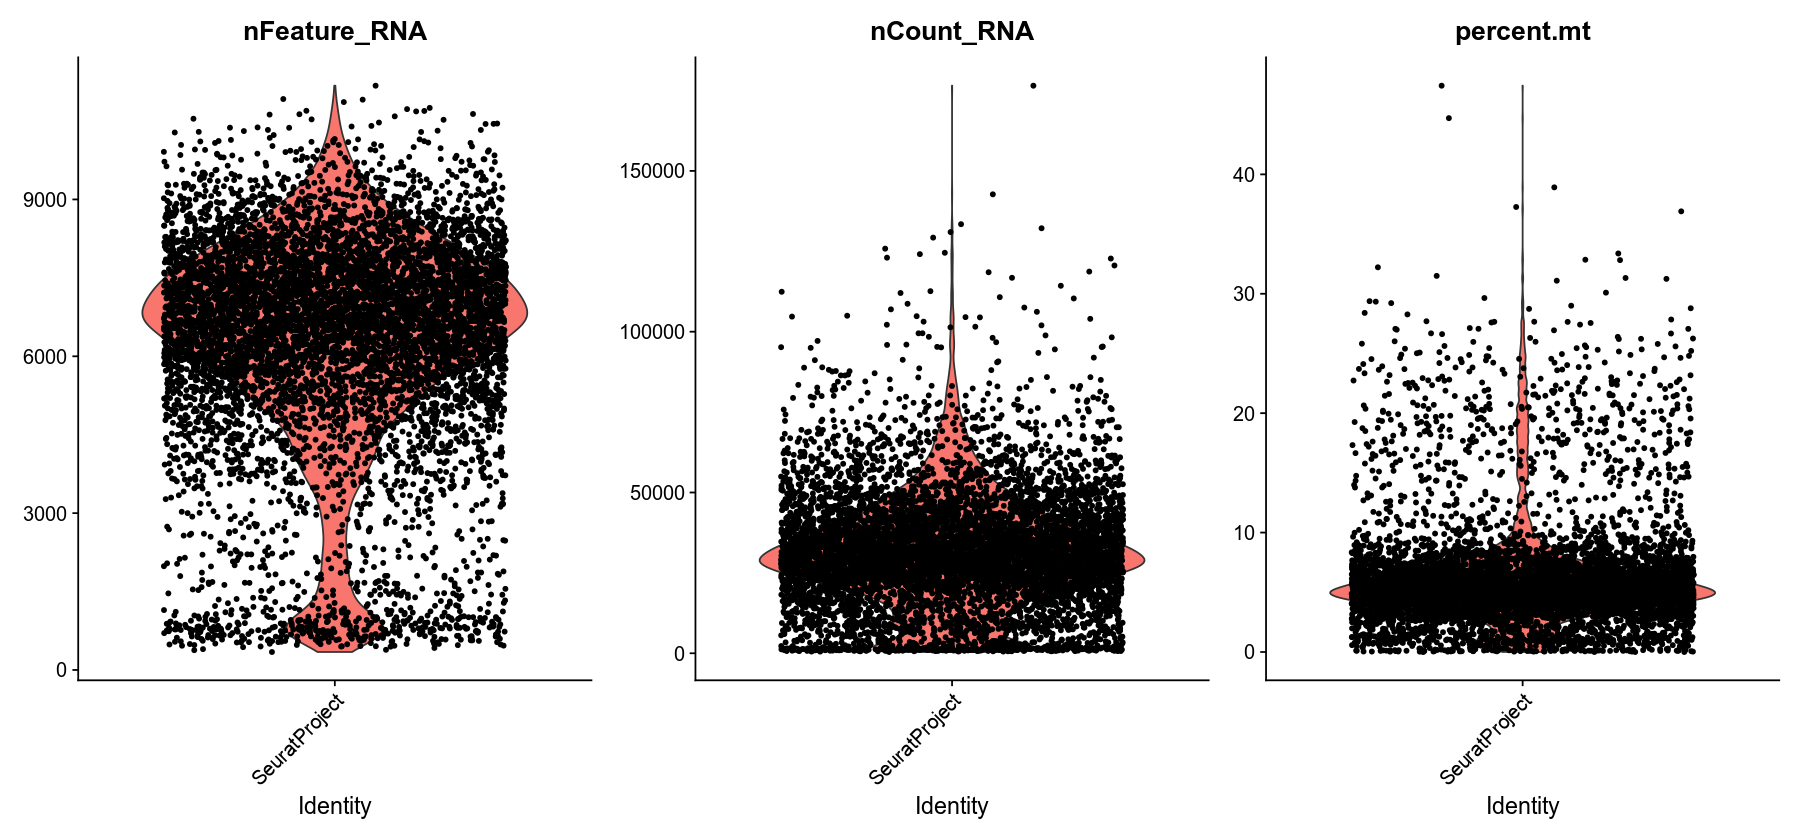

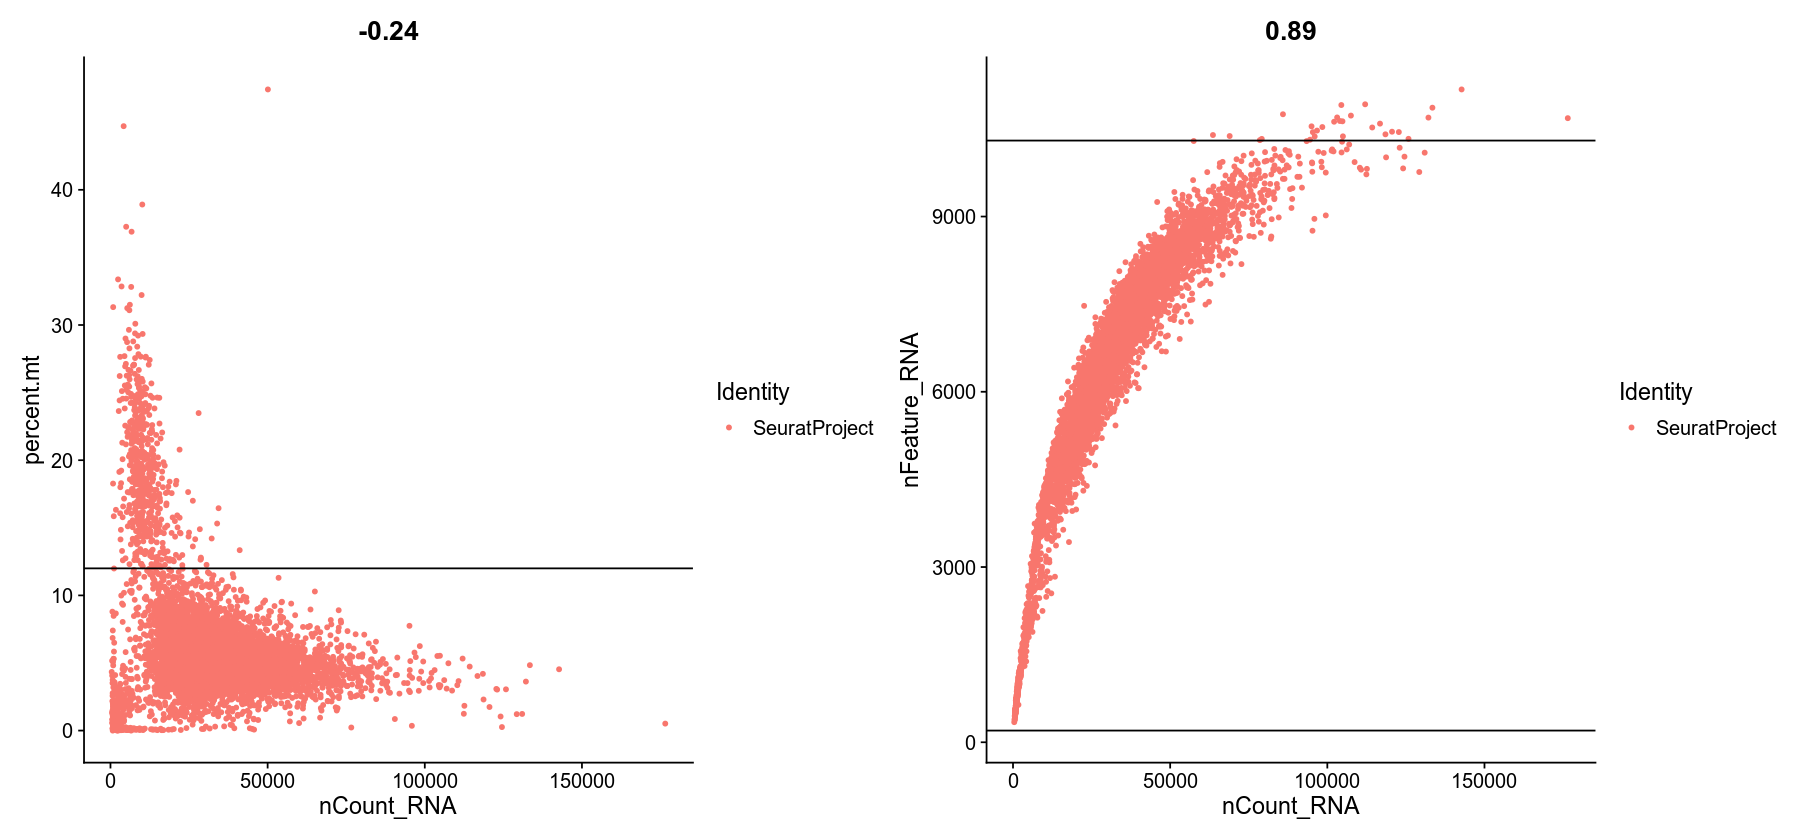

In [8]:
options(repr.plot.width=15, repr.plot.height=7)
CRISPRi_seurat[["percent.mt"]] <- PercentageFeatureSet(CRISPRi_seurat, pattern = "^MT-")
VlnPlot(CRISPRi_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_hline(yintercept = 12)
plot2 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_hline(yintercept = 200) + geom_hline(yintercept = 10300)
plot1 + plot2

In [9]:
CRISPRi_seurat <- NormalizeData(CRISPRi_seurat, normalization.method = 'RC')

In [10]:
normalized_exp_CRISPRi <- GetAssayData(object = CRISPRi_seurat, assay = 'RNA', slot = "data")
meta = unique(CRISPRi_seurat@meta.data)
guides = unique(meta$guide)
guide_genes = stringr::str_sub(guides, start = 1, end = -4)
guide_genes = guide_genes[!guide_genes %in% 'NT']

In [11]:
NT_exp <- lapply(guide_genes, function(x) return(normalized_exp_CRISPRi[x , startsWith(as.character(meta$guide), 'NT')]))
names(NT_exp) <- guide_genes
guide_exp <- lapply(guides[!startsWith(as.character(guides), 'NT')], function(x) return(normalized_exp_CRISPRi[stringr::str_sub(x, start = 1, end = -4) , meta$guide == x]))
names(guide_exp) <- guide_genes

In [ ]:
## take elements of NT_exp and put into dataframe
NT_exp_df <- do.call(rbind, lapply(NT_exp, function(x) return(as.data.frame(t(x)))))
NT_exp_df = as.data.frame(t(NT_exp_df))
NT_exp_df = cbind(pivot_longer(NT_exp_df, everything(), names_to = 'gene', values_to = 'exp'), guide = 'NT')
NT_exp_df = NT_exp_df[,c('exp', 'gene', 'guide')]
guide_exp_df <- data.frame(exp = as.numeric(unlist(guide_exp)), gene = as.character(unlist(mapply(rep, names(guide_exp), as.numeric(lapply(guide_exp, length)), simplify = TRUE))), guide = as.character(unlist(mapply(rep, as.character(guides[!startsWith(as.character(guides), 'NT')]), as.numeric(lapply(guide_exp, length)), simplify = TRUE))))
exp_df = rbind(NT_exp_df, guide_exp_df)
gene_nms_to_correct = unique(exp_df$gene)
for (i in 1: length(gene_nms_to_correct)){
    exp_df$gene[exp_df$gene == gene_nms_to_correct[i]] = guide_genes[i]
}

saveRDS(exp_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_exp_df.rds')

head(exp_df)

,exp,gene,guide
,<dbl>,<chr>,<fct>
1,0.4726568,NELFE,NT
2,0.0000000,MIS18A,NT
3,0.4726568,SUPV3L1,NT
4,0.0000000,CDK1,NT
5,1.1816420,ENY2,NT
6,0.7089852,VRK1,NT


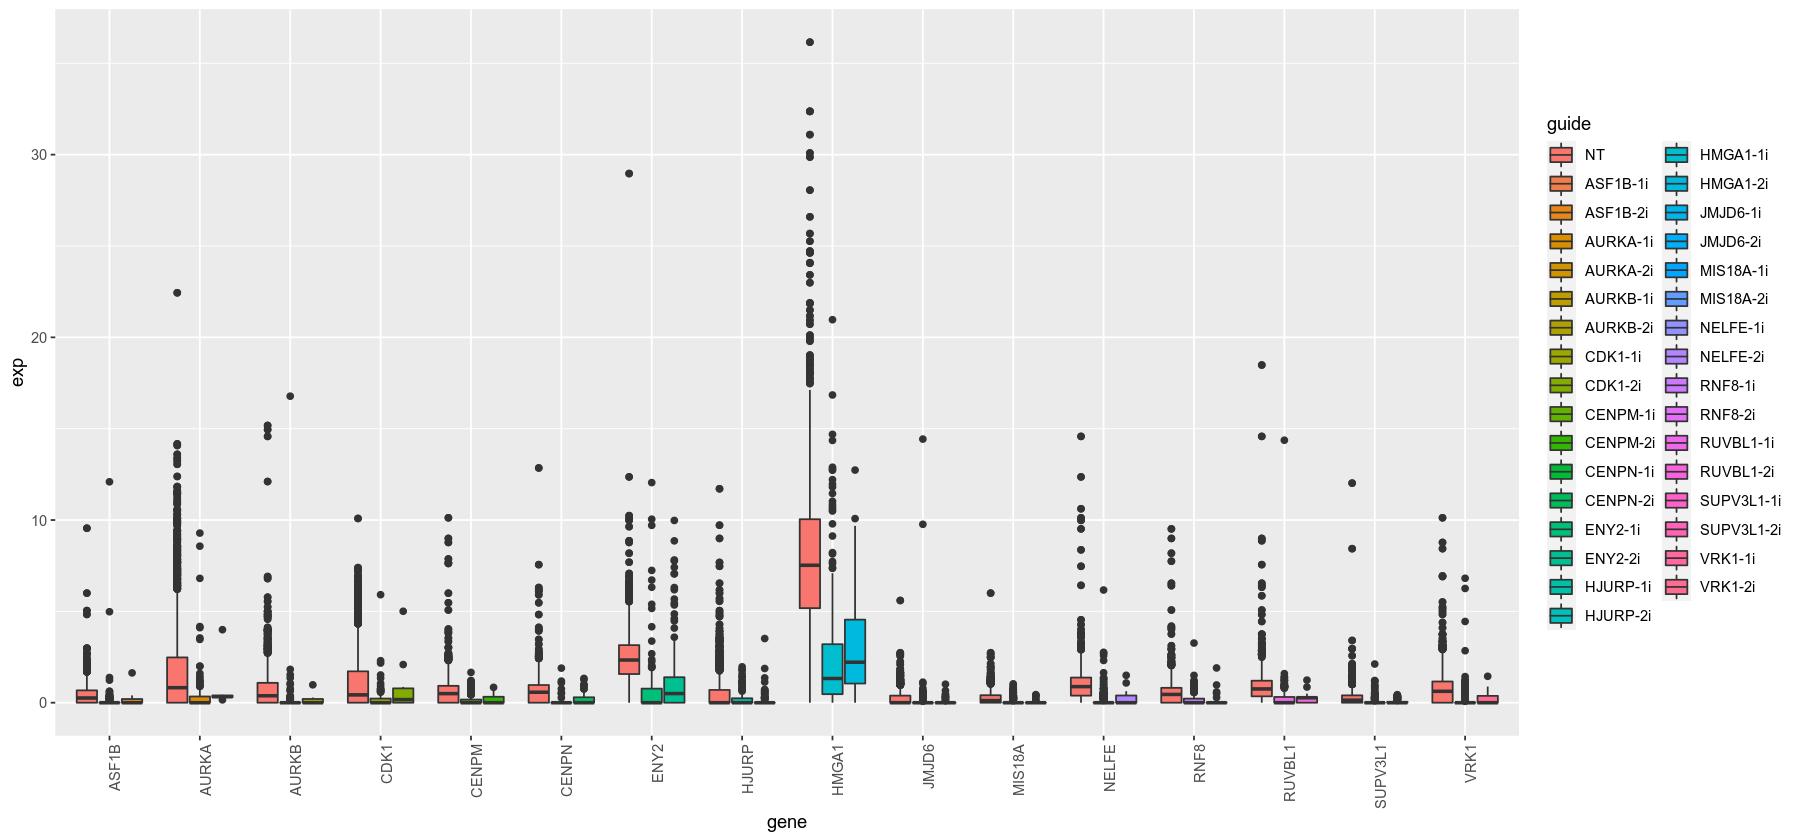

In [13]:
## knockdown effect on target gene (each dot is a cell)
## this plots expression of targeted genes by (1) NT guide, (2) targeting guide-1 and (3) targeting guide-2: pretty much every guide shows some knockdown
options(repr.plot.width=15, repr.plot.height=7)
ggplot(exp_df, aes(x = gene, y = exp, fill = guide)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

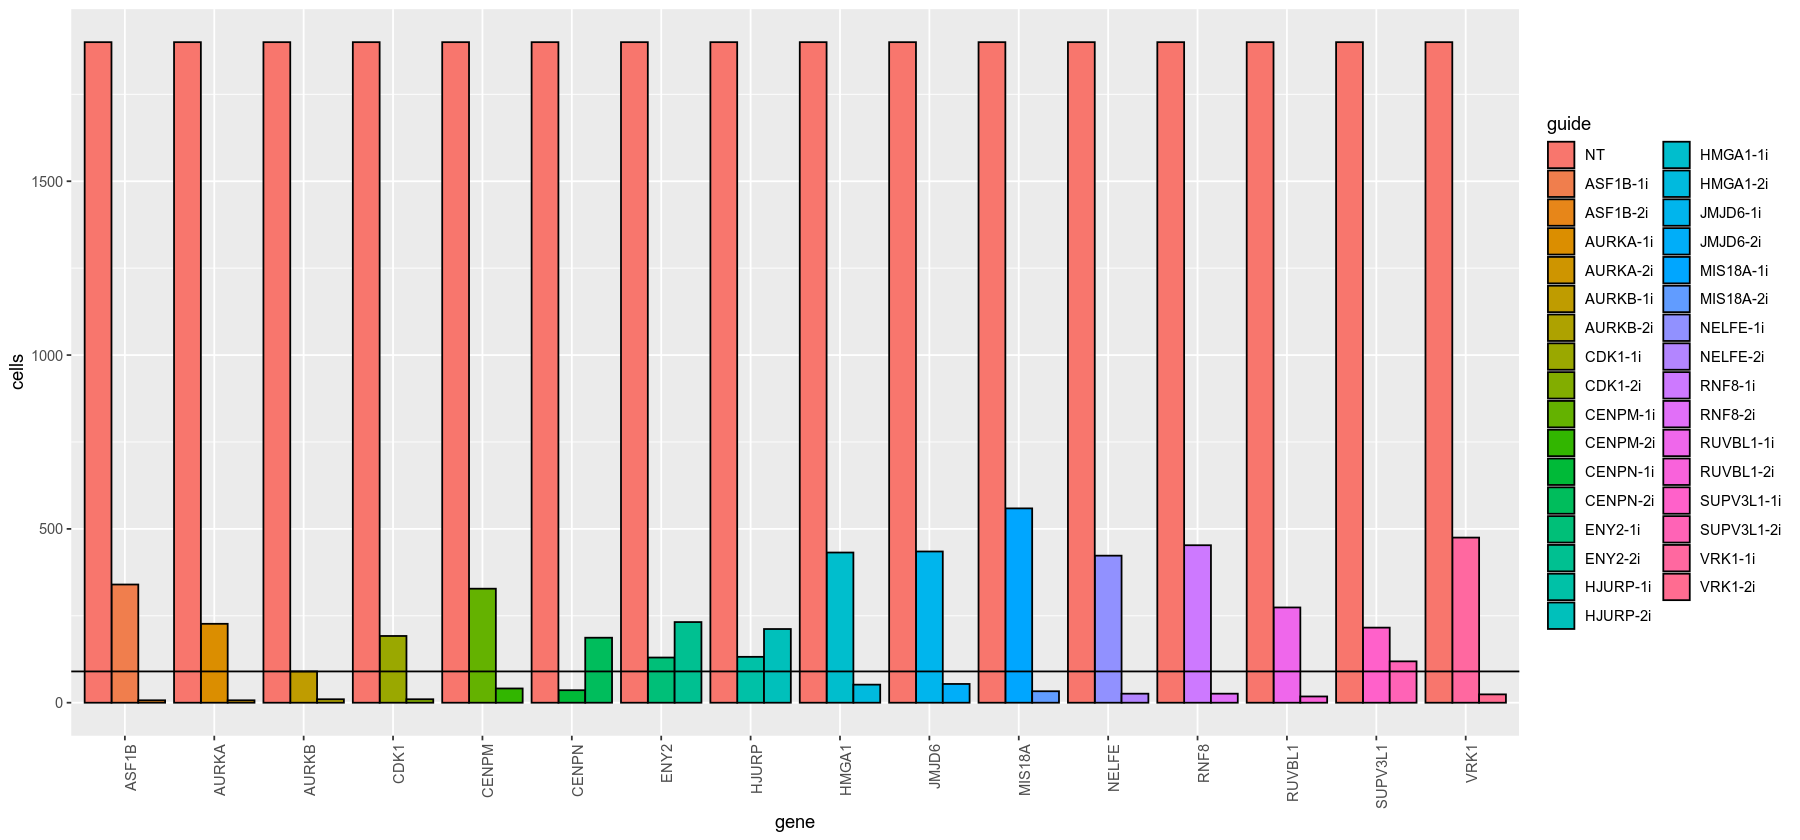

In [14]:
## # of cells for each of the guides above -- AURKB is the cell limiting gene with 90 cells as the max either of its guides picks up
cells_df = as.data.frame(table(meta$guide))
cells_df = cbind(gene = str_sub(cells_df$Var1, start = 1, end = -4), cells_df)
colnames(cells_df) = c('gene', 'guide', 'cells')
NT_sum = sum(cells_df[startsWith(as.character(cells_df$guide), 'NT'), 'cells'])
cells_df = cells_df[!startsWith(as.character(cells_df$guide), 'NT'),]
NT_df = data.frame(gene = unique(cells_df$gene), guide = 'NT', cells = NT_sum)
cells_df = rbind(cells_df, NT_df)
cells_df$guide = factor(cells_df$guide, levels = c('NT', levels(cells_df$guide)[!levels(cells_df$guide) %in% 'NT']))
ggplot(cells_df, aes(x = gene, y = cells, fill = guide)) + geom_bar(stat="identity", color="black", position=position_dodge()) + geom_hline(yintercept = 90) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


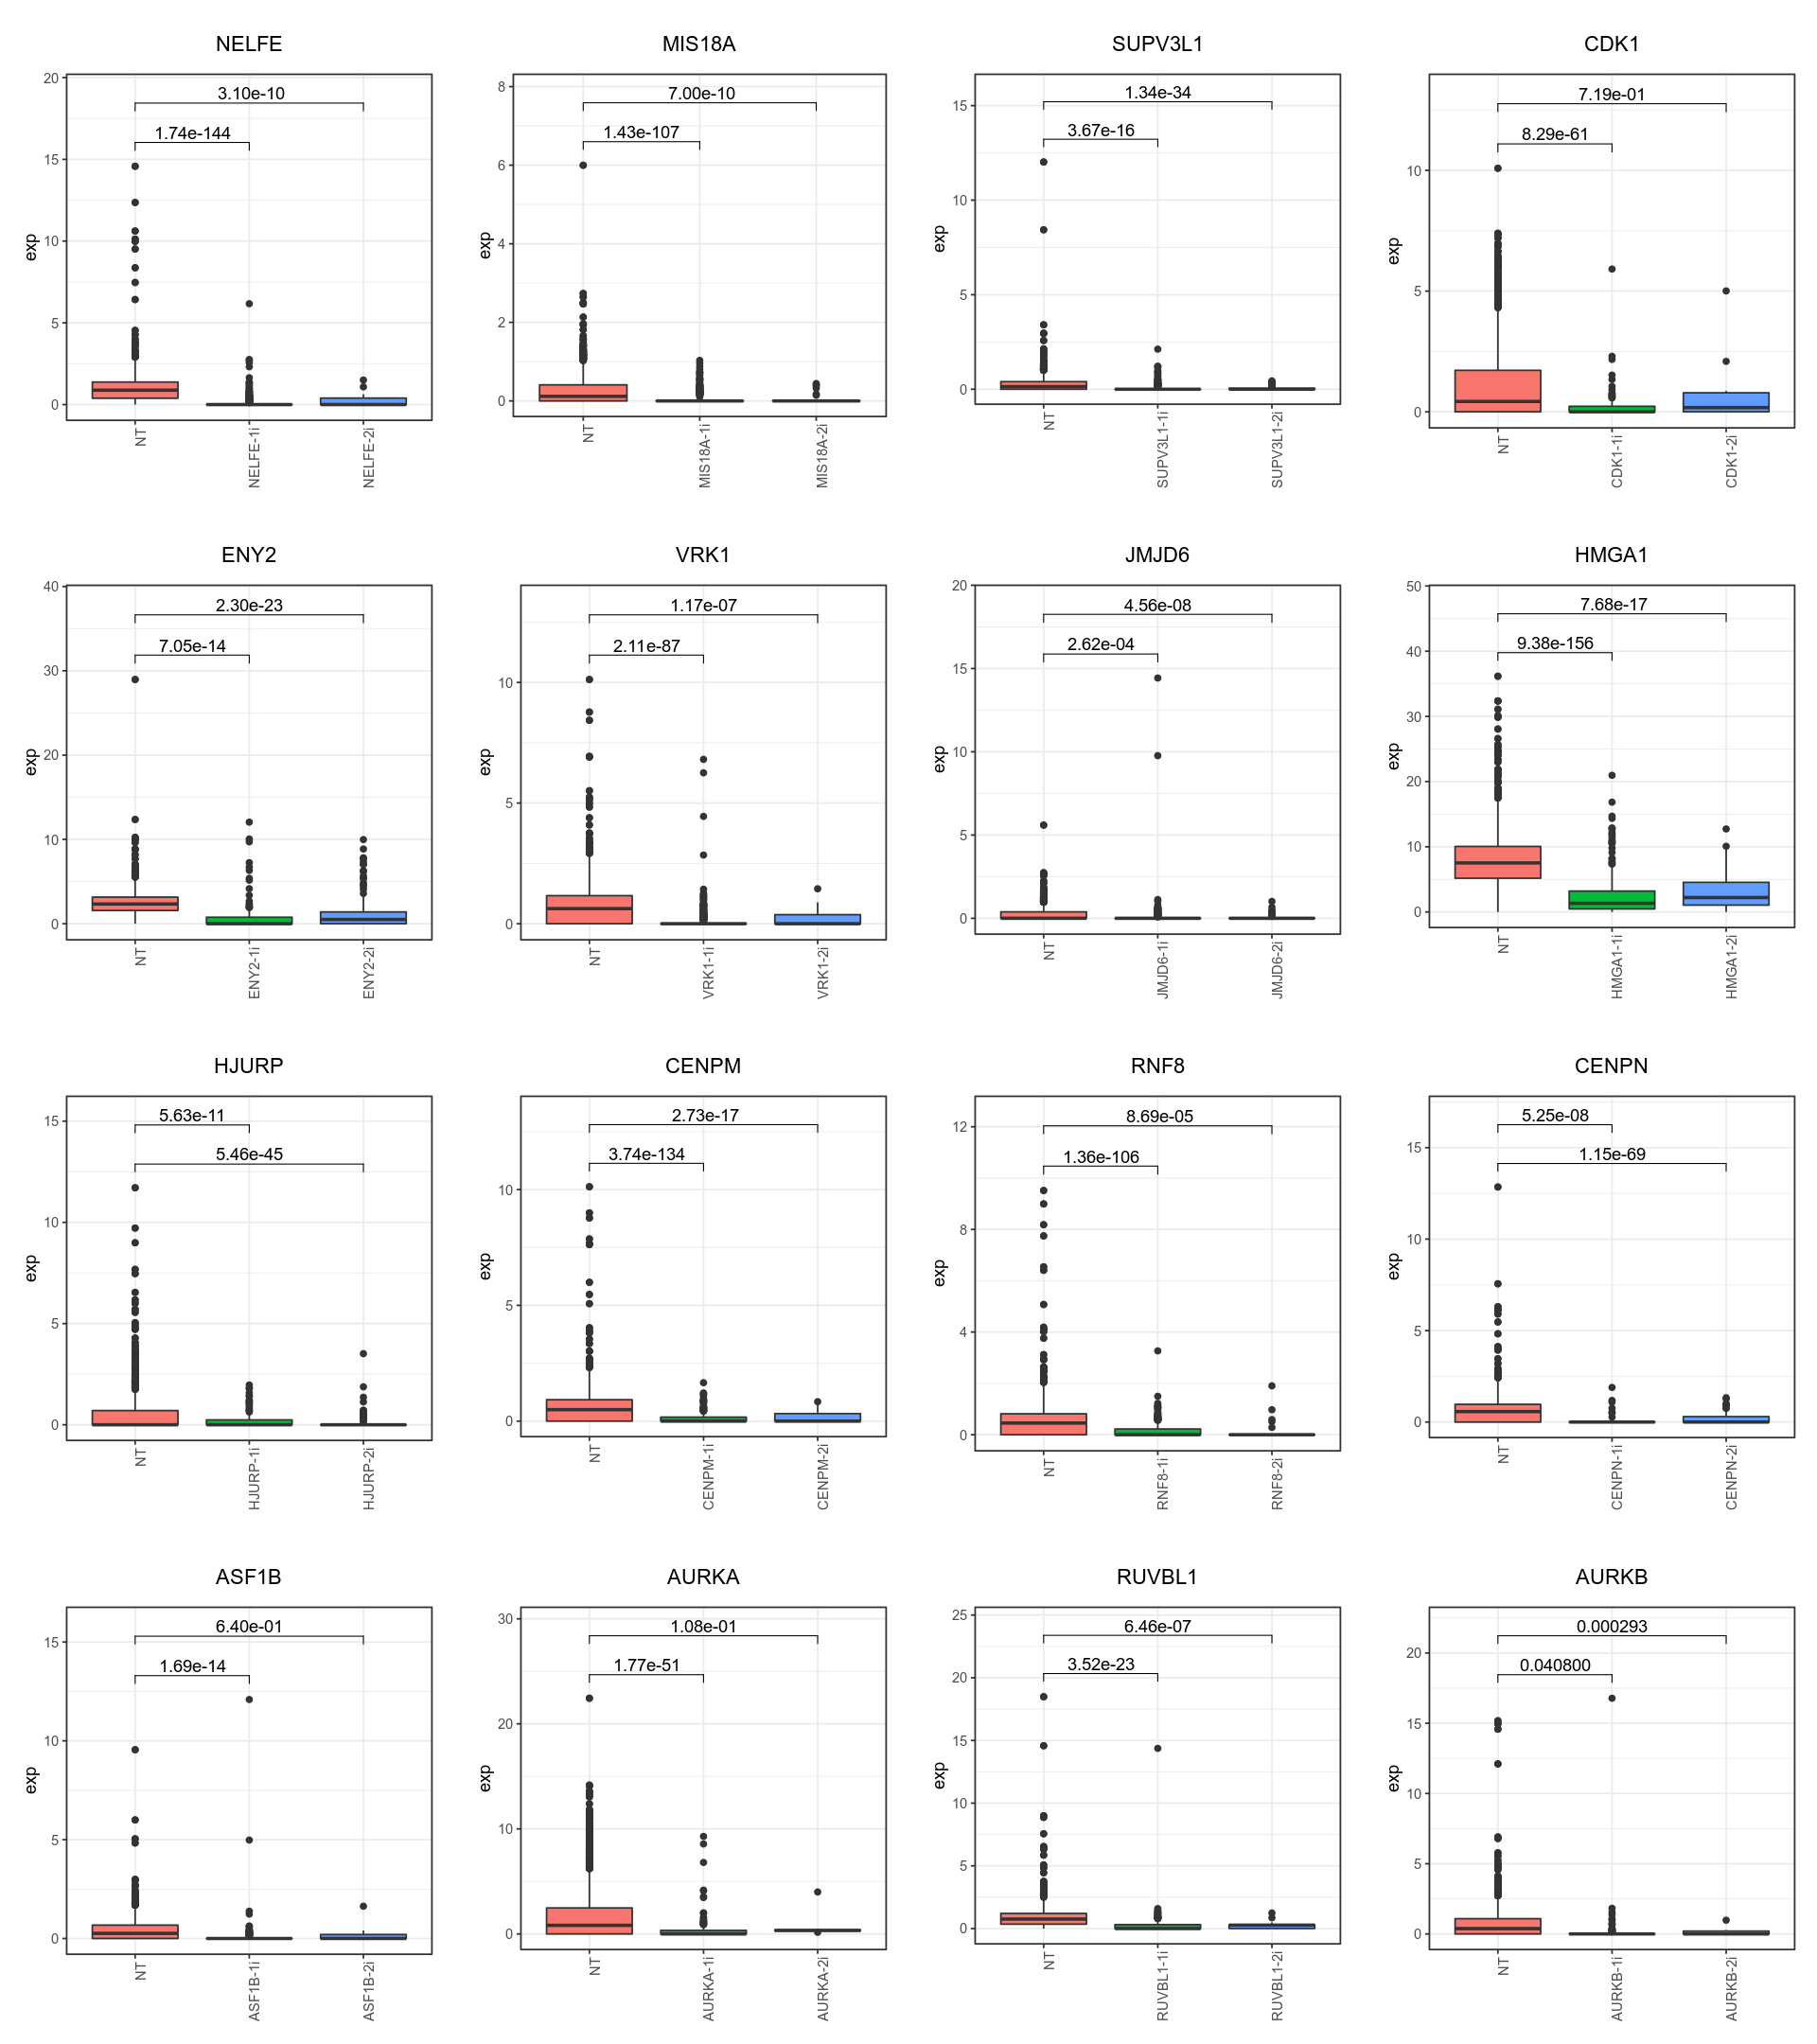

In [73]:
## facet plot by guide and perform t-test between NT and each guide
genes = unique(exp_df$gene)
kd_plots = list()
## plot by guide
options(repr.plot.width=15, repr.plot.height=7)
for (i in 1:length(genes)){
    df = exp_df %>% filter(gene == genes[i])
    guides = df %>% filter(guide != 'NT') %>% as.data.frame()
    guides = as.character(unique(guides$guide))
    upper_lim = max(as.data.frame(df %>% filter(gene == genes[i]))$exp)*1.1
    test1 = t.test(as.data.frame(df %>% filter(gene == genes[i] & guide == 'NT'))$exp, as.data.frame(df %>% filter(gene == genes[i] & guide == guides[1]))$exp)
    test2 = t.test(as.data.frame(df %>% filter(gene == genes[i] & guide == 'NT'))$exp, as.data.frame(df %>% filter(gene == genes[i] & guide == guides[2]))$exp)
    stat.test = data.frame(group1 = c('NT', 'NT'), group2 = c(guides[1], guides[2]), p = c(signif(test1$p.value, 3), signif(test2$p.value, 3)))
    stat.test = as.data.frame(apply(stat.test, 2, as.character))

    kd_plots[[i]] = df %>% ggplot(aes(x = guide, y = exp)) + geom_boxplot(aes(fill = guide)) + theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1), plot.title = element_text(hjust = 0.5, margin = margin(0,0,12,0)), plot.margin = unit(c(0.8, 0.5, 0.5, 0.5), 'cm'),
    axis.title.x = element_blank(), legend.position = 'none') + 
    ggtitle(genes[i]) + stat_pvalue_manual(stat.test, label = 'p', y.position = upper_lim, step.increase = 0.15) + coord_cartesian(clip = 'off', ylim = c(0, upper_lim*1.2))
}

library(ggpubr)
options(repr.plot.width=16, repr.plot.height=18)
ggarrange(plotlist = kd_plots, ncol = 4, nrow = 4)


In [15]:
head(arrange(cells_df, cells), 20)

,gene,guide,cells
,<fct>,<fct>,<int>
2,ASF1B,ASF1B-2i,7
4,AURKA,AURKA-2i,7
6,AURKB,AURKB-2i,10
8,CDK1,CDK1-2i,10
33,RUVBL1,RUVBL1-2i,18
37,VRK1,VRK1-2i,24
24,NELFE,NELFE-2i,26
31,RNF8,RNF8-2i,26
22,MIS18A,MIS18A-2i,33


In [203]:
### edit ### try to maximize cells kept: may need to keep both guides from most genes to maximize cells kept
### may need to repeat analysis downstream of this notebook

## due to variability in knockdown between guides for same gene and it's effect on CV, we will keep guide with the highest cell count
## thankfully guide with lowest cell count -- AURKB -- has the vast majority of its cells in one guide
cells_df %>% filter(!guide == 'NT') %>% group_by(gene) %>% summarise(cells = max(cells)) -> cells_df_max
cells_df %>% filter(!guide == 'NT') %>% filter(cells %in% cells_df_max$cells) %>% select(guide, cells) -> guides_to_keep
write.csv(guides_to_keep, '/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/CRISPRi_guides_to_keep_and_analyze.csv')
guides_to_keep


,guide,cells
,<fct>,<int>
1,ASF1B-1i,340
3,AURKA-1i,227
5,AURKB-1i,90
7,CDK1-1i,192
9,CENPM-1i,328
12,CENPN-2i,187
14,ENY2-2i,232
16,HJURP-2i,212
17,HMGA1-1i,432
